## Compression with ZFP and FPZIP

In [1]:
import zfpy
import fpzip
import numpy as np
from lossycomp.plots import mult_plot, single_plot, plot_history

In [2]:
##### ZFP - LOSSLESS ######
my_array = np.arange(1, 20)
compressed_data = zfpy.compress_numpy(my_array)
decompressed_array = zfpy.decompress_numpy(compressed_data)

# confirm lossless compression/decompression
np.testing.assert_array_equal(my_array, decompressed_array)

print("ZFP - LOSSLESS")
print("# Bytes data:", my_array.nbytes)
print("# Bytes compressed data:", len(compressed_data)) 
print("# Bytes decompressed data:", decompressed_array.nbytes)

ZFP - LOSSLESS
# Bytes data: 152
# Bytes compressed data: 64
# Bytes decompressed data: 152


In [3]:
##### ZFP - LOSSY ######
compressed_data = zfpy.compress_numpy(my_array, tolerance=1e-3)
decompressed_array = zfpy.decompress_numpy(compressed_data)

# Note the change from "equal" to "allclose" due to the lossy compression
#np.testing.assert_array_equal(my_array, decompressed_array)

print("ZFP - LOSSY")
print("# Bytes data:", my_array.nbytes)
print("# Bytes compressed data:", len(compressed_data))
print("# Bytes decompressed data:", decompressed_array.nbytes)

ZFP - LOSSY
# Bytes data: 152
# Bytes compressed data: 64
# Bytes decompressed data: 152


In [8]:
zfpy.?

AttributeError: module 'zfpy' has no attribute 'getattr'

In [4]:
np.testing.assert_allclose(my_array, decompressed_array, atol=1)  #It works ith atol=1??

In [5]:
##### FPZIP - LOSSY ######
data = np.array(np.arange(1, 20), dtype=np.float32) # up to 4d float or double array
# Compress data losslessly, interpreting the underlying buffer in C (default) or F order.
compressed_bytes = fpzip.compress(data, precision=16, order='C') # returns byte string
# Back to 3d or 4d float or double array, decode as C (default) or F order.
data_again = fpzip.decompress(compressed_bytes, order='C') 
print("FPZIP - LOSSY")
print("# Bytes data:", data.nbytes)
print("# Bytes compressed data:", len(compressed_bytes)) #is that how you meassure how many bytes? 
print("# Bytes decompressed data:", data_again[0,0,0].nbytes) 

FPZIP - LOSSY
# Bytes data: 76
# Bytes compressed data: 52
# Bytes decompressed data: 76


In [6]:
np.testing.assert_allclose(data, data_again[0,0,0], atol=1e-03)

## Testing with climate Data

In [3]:
import dask
from collections import OrderedDict
from lossycomp.dataLoader import DataGenerator, data_preprocessing, split_data, norm_data

dask.config.set(**{'array.slicing.split_large_chunks': False})

import xarray as xr
test = xr.open_mfdataset('/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc', combine='by_coords')
test_data = test.sel(time=slice('1979-01-14T16:00:00','1979-01-15T07:00:00'),level = slice(978,1000), longitude=slice(-180,180), latitude=slice(90,-90))
test_data = test_data.transpose('time', 'latitude', 'longitude', 'level')
test_data = test_data['t'].values
test_data = test_data[:,0:720,:,:]
test_data.shape

(16, 720, 1440, 1)

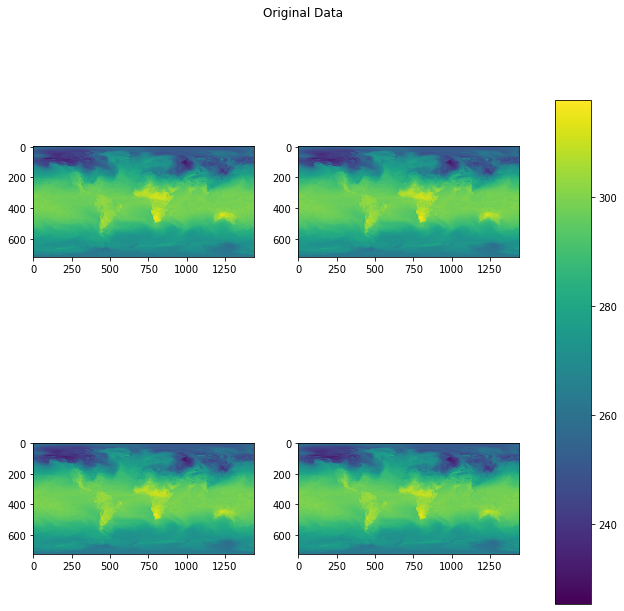

In [104]:
test_data_a = np.expand_dims(test_data, axis=0)
mult_plot(test_data_a, 2, 2, "Original Data", test_data.min(), test_data.max())

In [10]:
compressed_bytes = fpzip.compress(test_data, precision=16, order='C') # returns byte string max 32 precision?
compressed_bytes
data_again = fpzip.decompress(compressed_bytes, order='C') 

In [12]:
print("# Bytes data:", test_data.nbytes)
print("# Bytes compressed data:", len(compressed_bytes))
print("# Bytes decompressed data:", data_again.nbytes) 

# Bytes data: 147456
# Bytes compressed data: 5658
# Bytes decompressed data: 147456


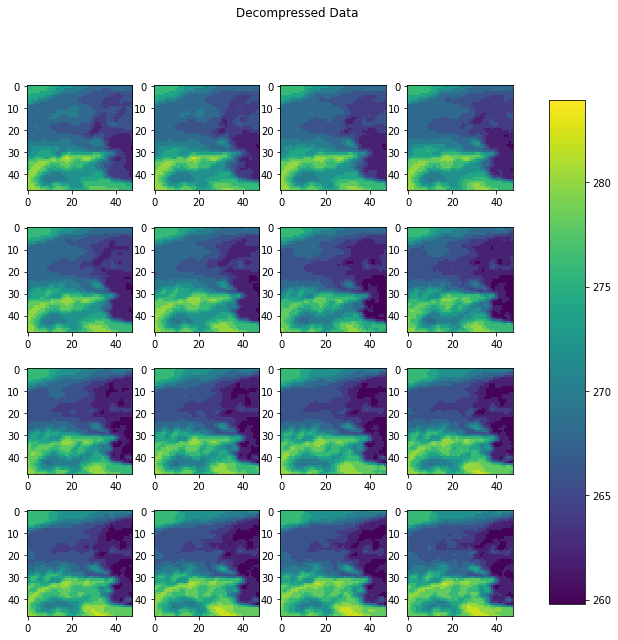

In [13]:
data_again = np.expand_dims(data_again, axis=0)
mult_plot(data_again, 4, 4, "Decompressed Data", test_data.min(), test_data.max())

In [14]:
help(zfpy.compress_numpy)

Help on built-in function compress_numpy in module zfpy:

compress_numpy(...)
    compress_numpy(ndarray arr, double tolerance=-1, double rate=-1, int precision=-1, write_header=True) -> bytes



In [44]:
compressed_data = zfpy.compress_numpy(test_data,tolerance=0.9)
decompressed_array = zfpy.decompress_numpy(compressed_data)
#np.testing.assert_allclose(test_data, decompressed_array, atol=0.003)

In [45]:
print("# Bytes data:", test_data.nbytes)
print("# Bytes compressed data:", len(compressed_data))
print("# Bytes decompressed data:", decompressed_array.nbytes) 
print("Compression ratio:", len(compressed_data)  / test_data.nbytes)

# Bytes data: 147456
# Bytes compressed data: 67216
# Bytes decompressed data: 147456
Compression ratio: 0.4558376736111111


In [3]:
compression_r = []
val = [0, 0.01, 0.1,1,10,100,1000,10000, 100000, 100000]
error = []
for i in val:
    compressed_data = zfpy.compress_numpy(test_data,tolerance=i)
    compression_r.append(test_data.nbytes/ len(compressed_data) ) #before/after = compression factor
    decompressed_array = zfpy.decompress_numpy(compressed_data)
    error.append(np.abs(test_data.flatten()- decompressed_array.flatten()).max())

Text(0, 0.5, 'Compression factor')

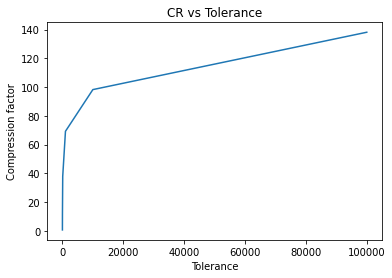

In [4]:
import matplotlib.pyplot as plt
plt.plot(val, compression_r)
plt.title('CR vs Tolerance')
plt.xlabel('Tolerance')
plt.ylabel('Compression factor')

/opt/bwhpc/common/devel/jupyter_ml/lib64/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Abs Error')

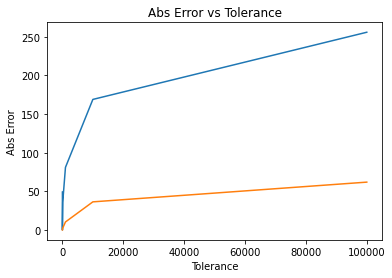

In [7]:
cal = np.power(np.floor(np.log2(val)), 2)
plt.plot(val, cal )
plt.plot(val, error )
plt.title('Abs Error vs Tolerance')
plt.xlabel('Tolerance')
plt.ylabel('Abs Error')

In [4]:
import math

tol = 2000
compressed_data = zfpy.compress_numpy(test_data, tolerance = tol)   ## says |data-decompressed| <= 2^(floor(log2(tolerance)))
decompressed_array = zfpy.decompress_numpy(compressed_data)
#print("Tolerance:", math.pow(2, math.floor(math.log2(tol))))
print("Compression factor:", test_data.nbytes/ len(compressed_data))

error = np.abs(test_data.flatten()- decompressed_array.flatten())
print("")
print("Data Original")
print("=======")
print("Mean:", test_data.mean())
print("Variance:", test_data.var())
print("Max Val:", test_data.max())
print("Min Val:", test_data.min())
print("")
print("Decompressed")
print("=======")
print("Mean:", decompressed_array.mean())
print("Variance:", decompressed_array.var())
print("Max Val:", decompressed_array.max())
print("Min Val:", decompressed_array.min())
print("")
print("Error")
print("=======")
print("Mean:", error.mean())
print("Variance:", error.var())
print("Max error:", error.max())
print("Min error:", error.min())
print("")

# But compares it to this:
np.testing.assert_allclose(test_data, decompressed_array, atol = tol) ## says |data-decompressed| <= atot + rtot * abs(decompressed)

error2 = test_data.flatten()- decompressed_array.flatten()
plt.hist(error2)
plt.title('Error Histogram')
plt.xlabel('Kelvin')
plt.ylabel('Count')

Compression factor: 76.1506045666125

Data Original
Mean: 278.9894
Variance: 302.65555
Max Val: 319.0653
Min Val: 222.65034

Decompressed
Mean: 278.4855
Variance: 293.54285
Max Val: 320.0
Min Val: 224.0

Error
Mean: 1.2427034
Variance: 0.83529526
Max error: 16.193909
Min error: 0.0



NameError: name 'plt' is not defined

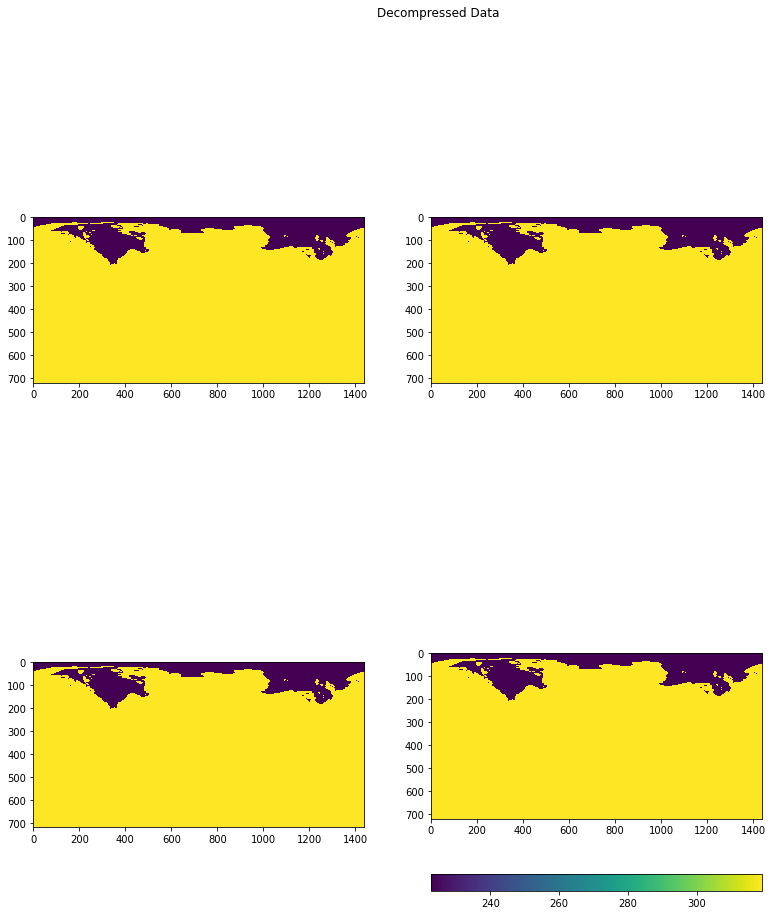

In [29]:
data_again = np.expand_dims(decompressed_array , axis=0)
mult_plot(data_again, 2, 2, "Decompressed Data", test_data.min(), test_data.max())

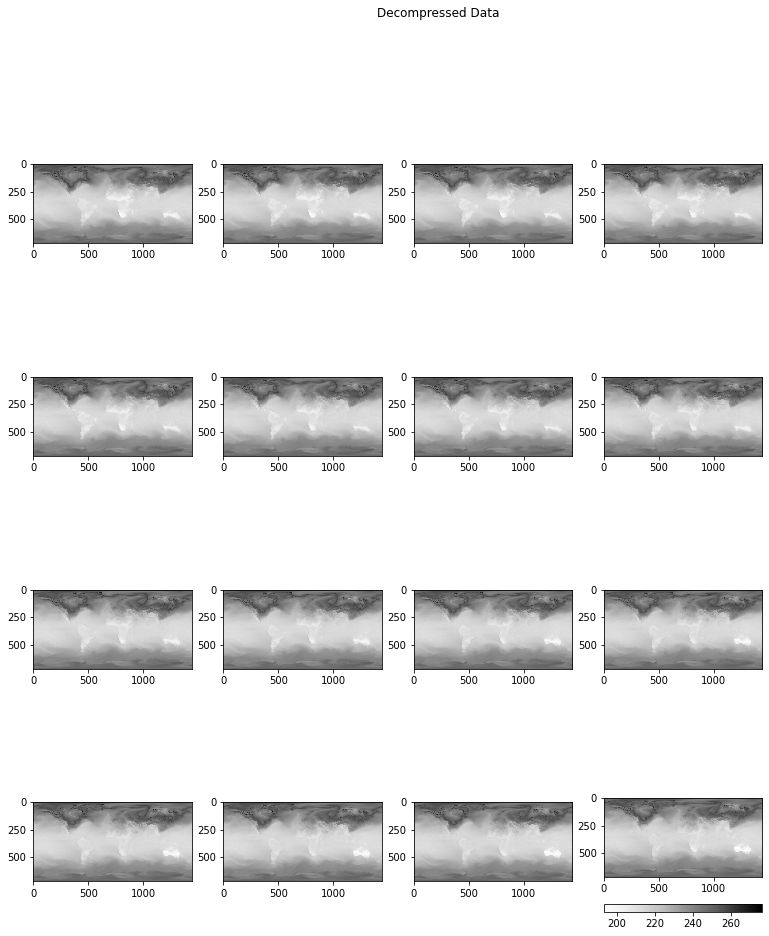

In [30]:
diff = np.expand_dims(abs(test_data - decompressed_array) , axis=0)
mult_plot(diff, 4, 4, "Decompressed Data", diff.min(), diff.max(),  'Greys')